Implementing Channels
=====================

Wireless propagation channels are a core concept in the physical layer modeling of communication and sensing systems.
In essence, they describe the behaviour of electromagnetic waves during their propagation between devices capable of transmitting electromagnetic radiation, receiving electromagnetic radation, or both.
Within Hermes' API, channels are addressed by the [Channel Module](../api/channel.rst), with each implemented channel model inheriting from a common [Channel](../api/channel.channel.rst) base class.

Adding a new channel model to the set of provided implementations is rather straightfoward.
On the most fundamental level, each channel model class is expected to provide only an [impulse_response](../api/channel.channel.rst#hermespy.channel.channel.Channel.impulse_response) generation method.
To demonstrate the API workflow, we will implement a basic channel only introducing a random phase shift to the propagated waveform, no time of flight delays or multiple antenna scenarios are considered:

In [5]:
import numpy as np

from hermespy.channel import Channel


class PhaseShiftChannel(Channel):
    
    def impulse_response(self, num_samples: int, sampling_rate: float) -> np.ndarray:
        
        if self.receiver.num_antennas != 1 or self.transmitter.num_antennas != 1:
            raise RuntimeError("Phase shift channel only supports SISO links")
        
        phase_shift = np.exp(2j * self._rng.normal(0, np.pi))
        impulse_response = phase_shift * np.ones((num_samples, 1, 1, 1), dtype=complex)
        
        return impulse_response

During simulation runtime, the impulse response routine will be called for each channel propagation over a single link configured to the newly created *PhaseShiftChannel*.
It is expected to return a four-dimensional numpy tensor modeling a channel impulse sampled *num_samples* times at frequency *sampling_rate*.
The first tensor dimension denotes the number of time-domain impulse response samples, the second and third dimension the number of transmit and receive antennas, and the fourth dimension the impulse response of each sample instance, respectively.

We can now plug the newly generated channel model into a simulation scenario evaluating an [OFDM waveform](../api/modem.waveform_generator_ofdm.rst) with access to ideal channel state information, equalizing the channel by [zero forcing](../api/modem.waveform_generator_ofdm.rst#hermespy.modem.waveform_generator_ofdm.OFDMZeroForcingChannelEqualization):

──────────────────────────────────── Simulation Campaign ────────────────────────────────────

[12:54:01] Launched simulation campaign with 24 dedicated actors          ]8;id=223194;file://D:\hermespy\hermespy\core\monte_carlo.py\monte_carlo.py]8;;\:]8;id=985054;file://D:\hermespy\hermespy\core\monte_carlo.py#1691\1691]8;;\

           Generating a maximum of 1100 = 100 x 11 samples inspected by 1 ]8;id=248435;file://D:\hermespy\hermespy\core\monte_carlo.py\monte_carlo.py]8;;\:]8;id=406691;file://D:\hermespy\hermespy\core\monte_carlo.py#1711\1711]8;;\
           evaluators                                                                        
                                                                                             

Simulation Grid                                                              
┏━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Dimension ┃ Sections                                                      ┃
┡━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ snr       │ 1.00 2.90 4.80 6.70 8.60 10.50 12.40 14.30 16.20 18.10 20.00  │
└───────────┴───────────────────────────────────────────────────────────────┘

Output()

[12:54:14] Simulation finished after 12.54 seconds                        ]8;id=832918;file://D:\hermespy\hermespy\core\monte_carlo.py\monte_carlo.py]8;;\:]8;id=812454;file://D:\hermespy\hermespy\core\monte_carlo.py#1852\1852]8;;\

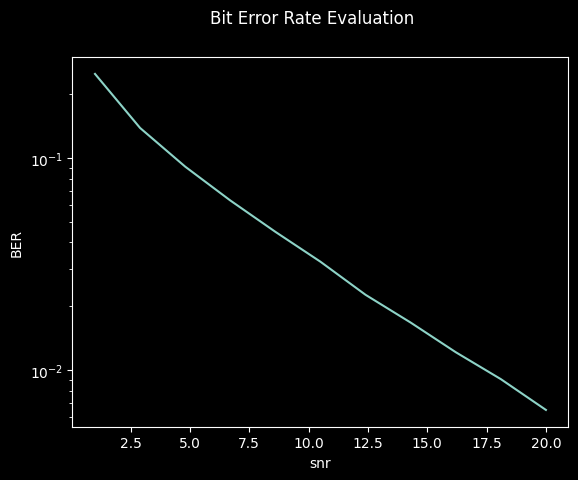

In [6]:
import matplotlib.pyplot as plt

from hermespy.simulation import Simulation
from hermespy.modem import BitErrorEvaluator, DuplexModem, ElementType, FrameElement, FrameResource, FrameSymbolSection, OFDMIdealChannelEstimation, OFDMWaveform, OFDMZeroForcingChannelEqualization


# Create a new Monte Carlo simulation
simulation = Simulation()

# Add a single device, operated by a communication modem
operator = DuplexModem()
operator.device = simulation.new_device()
operator.reference = operator.device

# Configure an OFDM waveform with a frame consisting of a single symbol section
operator.waveform_generator = OFDMWaveform(resources=[FrameResource(elements=[FrameElement(ElementType.DATA, 1200)])],
                                           structure=[FrameSymbolSection(pattern=[0])])

# Add channel estimation and equalization routines
operator.waveform_generator.channel_estimation = OFDMIdealChannelEstimation()
operator.waveform_generator.channel_equalization = OFDMZeroForcingChannelEqualization()

# Configure our newly implemented channel model
simulation.scenario.set_channel(operator.device, operator.device, PhaseShiftChannel())

# Configure a parameter sweep over the receiver SNR, effectively simulating an AWGN channel
simulation.new_dimension('snr', np.linspace(1, 20, 11, endpoint=True))

# Evaluate the BER
simulation.add_evaluator(BitErrorEvaluator(operator, operator))

# Run the simulation and plot the results
result = simulation.run()
result.plot()
plt.show()

We can hilight the channel effect by disabling the zero-forcing channel equalization routine for the configured OFDM waveform.

In this case, the communication bit error rate should roughly approximate $\tfrac{1}{2}$, indicating that no information is exchanged and the bits are esentially random at the receiver.

──────────────────────────────────── Simulation Campaign ────────────────────────────────────

           Launched simulation campaign with 24 dedicated actors          ]8;id=402118;file://D:\hermespy\hermespy\core\monte_carlo.py\monte_carlo.py]8;;\:]8;id=820907;file://D:\hermespy\hermespy\core\monte_carlo.py#1691\1691]8;;\

           Generating a maximum of 1100 = 100 x 11 samples inspected by 1 ]8;id=303555;file://D:\hermespy\hermespy\core\monte_carlo.py\monte_carlo.py]8;;\:]8;id=726922;file://D:\hermespy\hermespy\core\monte_carlo.py#1711\1711]8;;\
           evaluators                                                                        
                                                                                             

Simulation Grid                                                              
┏━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Dimension ┃ Sections                                                      ┃
┡━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ snr       │ 1.00 2.90 4.80 6.70 8.60 10.50 12.40 14.30 16.20 18.10 20.00  │
└───────────┴───────────────────────────────────────────────────────────────┘

Output()

Output()

[12:54:27] Simulation finished after 12.96 seconds                        ]8;id=663882;file://D:\hermespy\hermespy\core\monte_carlo.py\monte_carlo.py]8;;\:]8;id=374881;file://D:\hermespy\hermespy\core\monte_carlo.py#1852\1852]8;;\

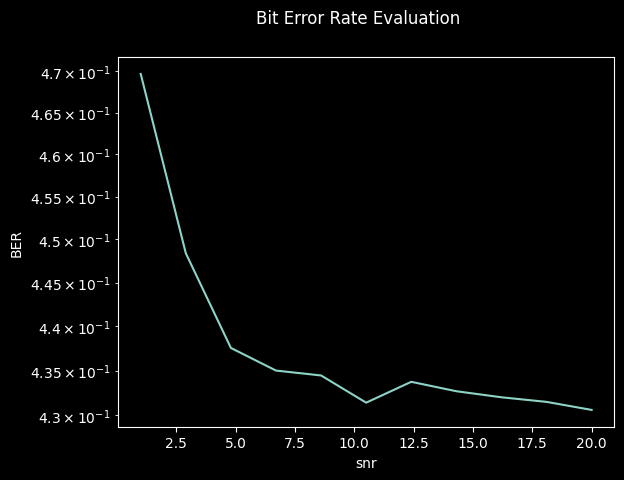

In [7]:
from hermespy.modem import OFDMChannelEqualization

# Disable channel equalization by replacing the ZF routine with the default stub
operator.waveform_generator.channel_equalization = OFDMChannelEqualization()

# Run the simulation and plot the results
result = simulation.run()
result.plot()
plt.show()